### Section 1 <br>Load Data "USA.gov Data From Bitly"

In [1]:
# LOAD DATA INTO A PANDAS DATAFRAME
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

records = [json.loads(line) for line in open("./datasets/example.txt")]
records_df = pd.DataFrame(records)
display(records_df.head())

,a,c,nk,tz,gr,g,h,l,al,hh,r,u,t,hc,cy,ll,_heartbeat_,kw
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,1.0,America/New_York,MA,A6qOVH,wfLQtf,orofrog,"en-US,en;q=0.8",1.usa.gov,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,http://www.ncbi.nlm.nih.gov/pubmed/22415991,1.331923e+09,1.331823e+09,Danvers,"[42.576698, -70.954903]",NaN,NaN
1,GoogleMaps/RochesterNY,US,0.0,America/Denver,UT,mwszkS,mwszkS,bitly,NaN,j.mp,http://www.AwareMap.com/,http://www.monroecounty.gov/etc/911/rss.php,1.331923e+09,1.308262e+09,Provo,"[40.218102, -111.613297]",NaN,NaN
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,US,1.0,America/New_York,DC,xxr3Qb,xxr3Qb,bitly,en-US,1.usa.gov,http://t.co/03elZC4Q,http://boxer.senate.gov/en/press/releases/0316...,1.331923e+09,1.331920e+09,Washington,"[38.9007, -77.043098]",NaN,NaN
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,BR,0.0,America/Sao_Paulo,27,zCaLwp,zUtuOu,alelex88,pt-br,1.usa.gov,direct,http://apod.nasa.gov/apod/ap120312.html,1.331923e+09,1.331923e+09,Braz,"[-23.549999, -46.616699]",NaN,NaN
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,0.0,America/New_York,MA,9b6kNl,9b6kNl,bitly,"en-US,en;q=0.8",bit.ly,http://www.shrewsbury-ma.gov/selco/,http://www.shrewsbury-ma.gov/egov/gallery/1341...,1.331923e+09,1.273672e+09,Shrewsbury,"[42.286499, -71.714699]",NaN,NaN


### Section 2<br>Operating System Analysis

In this notebook, we want to see what operating system that users use most of the time to perform URL shortening. The field or column which contains that kind of information is field **a**. So, we want to analyze that column.

In [2]:
field_a = records_df["a"]
for idx in field_a.head(3).values:
    print(idx + "\n")

Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11

GoogleMaps/RochesterNY

Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E; InfoPath.3)



In [3]:
# LET'S DROP NULL VALUE
records_temp = records_df[records_df["a"].notnull()]
print("WITH NAN VALUES: {}".format(records_df.shape)) # before dropping null value
print("AFTER DROPPING NAN VALUES: {}".format(records_temp.shape)) # after dropping null value

# NOW LET'S COMPUTE A VALUE WHETHER EACH ROW OF FIELD "a" IS USING WINDOWS OR NOT
os_data = np.where(records_temp["a"].str.contains("Windows"), "Windows", "Not Windows")
records_new = records_temp.assign(os=os_data)

# DON'F FORGET TO CHANGE EMPTY STRING "" TO "UNKNOWN" IN THE tz FIELD
tz_data = []
for idx in records_new["tz"]:
    if idx == "":
        tz_data.append("Unknown")
    else:
        tz_data.append(idx)
records_new.update({"tz": tz_data})

# PERFORMING COUNTS BY OS
os_counts = records_new["os"].value_counts()
tz_counts = records_new["tz"].value_counts()
display(os_counts, tz_counts[:10])

WITH NAN VALUES: (3560, 18)
AFTER DROPPING NAN VALUES: (3440, 18)


Windows        2246
Not Windows    1194
Name: os, dtype: int64

America/New_York       1228
Unknown                 506
America/Chicago         410
America/Los_Angeles     381
America/Denver          196
Europe/London            75
Pacific/Honolulu         37
Europe/Madrid            36
Asia/Tokyo               35
America/Sao_Paulo        33
Name: tz, dtype: int64

At this point, we successfully created a new field "os" that contains information of operating system that users use when shortening URL. If we want to go further, we can group the data by their timezones and operating system. By doing this, we'll know how time zones differences affect the use windows operating system.

In [4]:
group_tz_os = records_new.groupby(["tz", "os"])
display(group_tz_os.size().unstack()[:5])

# IT APPEARS THERE ARE SOME TIME ZONES THAT ONLY USE ONE TYPE OF OS,
# THIS REPRESENTS BY NaN VALUES, WE WOULD WANT TO REPLACE THIS NaN VALUES WITH 0
counts_tz_os = group_tz_os.size().unstack().fillna(0)
display(counts_tz_os[:5])

os,Not Windows,Windows
tz,,
,14.0,11.0
Africa/Cairo,2.0,NaN
Africa/Casablanca,NaN,1.0
Africa/Ceuta,NaN,2.0
Africa/Johannesburg,1.0,NaN


os,Not Windows,Windows
tz,,
,14.0,11.0
Africa/Cairo,2.0,0.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,1.0,0.0


In [5]:
# NOW LET'S SELECT ONLY THE TOP 10 OVERALL TIMEZONES

indexer = counts_tz_os.sum(1).argsort() # first let's construct an indexer
display(indexer[:5]) # bottom 10 overall timezones
display(indexer[-5:])# top 10 overall timezones

result = counts_tz_os.take(indexer[-10:])
display(result.head())

tz
                       17
Africa/Cairo           33
Africa/Casablanca      92
Africa/Ceuta           52
Africa/Johannesburg    27
dtype: int64

tz
Europe/Warsaw       15
Europe/Zurich       22
Pacific/Auckland    12
Pacific/Honolulu    97
Unknown             29
dtype: int64

os,Not Windows,Windows
tz,,
America/Sao_Paulo,11.0,22.0
Asia/Tokyo,13.0,22.0
Europe/Madrid,13.0,23.0
Pacific/Honolulu,11.0,26.0
Europe/London,30.0,45.0


Now, we managed to get top 10 overall time zones and grouped them by operating system they used. Now, the next step we want to do is make a barplot to see the result more clearer. We could also grouped the barplot by operating system they used. We can do this by using **sns barplot**.

In [6]:
# FIRST LET'S REARRANGE THE DATA FOR PLOTTING
result_stack = result.stack()
result_stack.name = "total"
print(type(result_stack))

result_new = result_stack.reset_index()
display(result_new)

# NEXT WE WOULD LIKE TO NORMALIZE THE RESULT BEFORE PLOTTING
# SO THAT WE COULD EASILY SEE THE RELATIVE PERCENTAGE OF WINDOWS AND NON WINDOWS USERS IN THE SMALLER GROUPS
def norm_total(group):
    group["normed_total"] = group["total"] / group["total"].sum()
    return group

result_plot = result_new.groupby("tz").apply(norm_total)
print(result_plot)

<class 'pandas.core.series.Series'>


,tz,os,total
0,America/Sao_Paulo,Not Windows,11.0
1,America/Sao_Paulo,Windows,22.0
2,Asia/Tokyo,Not Windows,13.0
3,Asia/Tokyo,Windows,22.0
4,Europe/Madrid,Not Windows,13.0
5,Europe/Madrid,Windows,23.0
6,Pacific/Honolulu,Not Windows,11.0
7,Pacific/Honolulu,Windows,26.0
8,Europe/London,Not Windows,30.0
9,Europe/London,Windows,45.0


                     tz           os  total  normed_total
0     America/Sao_Paulo  Not Windows   11.0      0.333333
1     America/Sao_Paulo      Windows   22.0      0.666667
2            Asia/Tokyo  Not Windows   13.0      0.371429
3            Asia/Tokyo      Windows   22.0      0.628571
4         Europe/Madrid  Not Windows   13.0      0.361111
5         Europe/Madrid      Windows   23.0      0.638889
6      Pacific/Honolulu  Not Windows   11.0      0.297297
7      Pacific/Honolulu      Windows   26.0      0.702703
8         Europe/London  Not Windows   30.0      0.400000
9         Europe/London      Windows   45.0      0.600000
10       America/Denver  Not Windows   62.0      0.316327
11       America/Denver      Windows  134.0      0.683673
12  America/Los_Angeles  Not Windows  141.0      0.370079
13  America/Los_Angeles      Windows  240.0      0.629921
14      America/Chicago  Not Windows  149.0      0.363415
15      America/Chicago      Windows  261.0      0.636585
16            

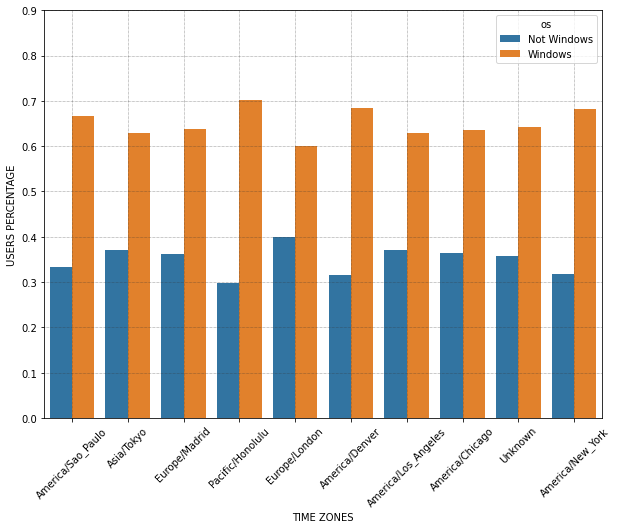

In [7]:
# FINALLY, WE MAKE THE BARPLOT

%matplotlib inline
plt.rcParams["figure.figsize"] = [4*2.5, 3*2.5]
sns.barplot(y="normed_total", x="tz", hue="os", data=result_plot)
plt.ylabel("USERS PERCENTAGE")
plt.xlabel("TIME ZONES")
plt.xticks(rotation=45)
plt.yticks([i*0.1 for i in range(10)])
plt.grid(color="#333", linestyle=":", linewidth=0.5)
plt.show()

From the barplot above, we now know about: 
* In many time zones (even though the numbers vary), users often use Windows operating system when they perform URL Shortening.
* In Pacific/Honolulu we see the highest Windows users percentage. But not only that, we also see the lowest Non Windows Users in the same time zones. This could means that people lived in Pacific/Honolulu do their work mostly on windows operating system. Or, **maybe**, they get their Windows OS at a considerably lower price compared to other time zones.